<a href="https://www.kaggle.com/code/ksenia5/transfer-learning-with-inceptionv3?scriptVersionId=123482635" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Transfer learning with InceptionV3 for multiclass object detection in images

Using the convolutional neural network [InceptionV3](https://keras.io/api/applications/inceptionv3/) pretrained on ImageNet data.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

from tensorflow.keras import layers # look at layers to decide which ones to keep/ retrain
from tensorflow.keras import Model

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import os
import shutil
from PIL import Image as PImage
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


## Load Data

Load image data, that is stored in directories - one directory for one object class

In [2]:
# Get paths to input image files and working directory
input_dir = '/kaggle/input/electronic-object-detection'
working_dir = '/kaggle/working'

# Get the object categores (labels)
categories = [f for f in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir,f)) ]
print(categories)

['USB stick', 'satellite dish device', 'magnifying glass', 'laptop', 'computer mouse', 'keyboard I', 'keys objects', 'server rack', 'phone', 'router']


In [3]:
# Create directory files strucutre in working directory to store train, test, val data
# with class subdirectories in each directory
for dataset in ["train", "test", "val"]:
    for cat in categories:
        dir_name = os.path.join("/kaggle/working",dataset, cat)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)

In [4]:
# Split 95 images in each class into train-test-val sets
train_size = 70
test_size = 20
val_size = 5

# Create a dictionary mapping class index to name
label_dict = {}

def splitData():
    for cat in categories:
        # map class index to object name
        class_num = categories.index(cat)
        label_dict[class_num] = cat
        
        # specify input directory
        path_input = os.path.join(input_dir, cat)
        
        # get each image, load, convert to rgb and save as jpg (get rid of alpha channel in rgba images)
        for i,f in enumerate(os.listdir(path_input)):
            try:
                if i <70:
                    # move 70 images to train set
                    path_working = os.path.join(working_dir, "train/"+ cat)
                    img = PImage.open(os.path.join(path_input,f))
                    try:
                        img = img.convert('RGB')
                    except Exception as e:
                        pass
                    img.save(os.path.join(path_working,f + ".jpg"))
#                     shutil.copyfile(os.path.join(path_input,f),os.path.join(path_working,f))
                elif i < 90:
                    # move the next 20 images to test folder 
                    path_working = os.path.join(working_dir, "test/" + cat)
                    img = PImage.open(os.path.join(path_input,f))
                    try:
                        img = img.convert('RGB')
                    except Exception as e:
                        pass
                    img.save(os.path.join(path_working,f+".jpg"))
#                     shutil.copyfile(os.path.join(path_input,f),os.path.join(path_working,f))    
                else:
                    # move the last 5 images to val folder
                    path_working = os.path.join(working_dir, "val/" + cat)
                    img = PImage.open(os.path.join(path_input,f))
                    try:
                        img = img.convert('RGB')
                    except Exception as e:
                        pass
                    img.save(os.path.join(path_working,f + ".jpg"))
#                     shutil.copyfile(os.path.join(path_input,f),os.path.join(path_working,f))
                    
            except Exception as e:
                pass

splitData()

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [5]:
# # print(len(os.listdir('/kaggle/working/val/keyboard I')))
# # save output
# shutil.make_archive("/kaggle/working/split", 'zip', '/kaggle/working')

## Preprocess input
Use inception_v3.preprocess_input for inceptionV3 model. This will scale input pixels between -1 and 1.

In [6]:
# Instantiate pre-trained model
pre_trained_model = InceptionV3(input_shape = (299,299,3),
                               include_top = False,
                               weights = 'imagenet')

87910968/87910968 [==============================] - 3s 0us/step


In [7]:
# lock pretrained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

In [8]:
# # To view model summary, with layer info
# pre_trained_model.summary()

In [9]:
# Get one of the layers
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
# and its output
last_output = last_layer.output

last layer output shape:  (None, 17, 17, 768)


In [10]:
# Define new model with output from "mixed7" layer
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation ='relu')(x) # hidden layer with 1024 nodes

# # add drop out to prevent overfitting
x = layers.Dropout(0.2)(x)
x = layers.Dense(10, activation='softmax')(x) # specify 10 output nodes

model = Model(pre_trained_model.input, x)



In [11]:
# # to view model layers
# model.summary()

In [12]:
model.compile(optimizer = RMSprop(lr = 0.001),
             loss = 'categorical_crossentropy',
             metrics= ['accuracy'])

In [13]:
# add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.,
#                                    rotation_range = 40,
#                                    width_shift_range = 0.2,
#                                    height_shift_range = 0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip = True
                                 )

In [14]:
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test"

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size = 5,
                                                   class_mode = "categorical",# for multiclass
                                                   target_size = (299,299))

validation_generator = test_datagen.flow_from_directory(test_dir,
                                                   batch_size = 5,
                                                   class_mode = "categorical",# for multiclass
                                                   target_size = (299,299))

Found 700 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [15]:
# Train the model

history = model.fit(train_generator, 
                    epochs=25, steps_per_epoch=20, 
                    validation_data = validation_generator, verbose = 1, validation_steps=3)


Epoch 1/25
20/20 [==============================] - 57s 3s/step - loss: 68.9821 - accuracy: 0.2100 - val_loss: 24.8598 - val_accuracy: 0.3333
Epoch 2/25
20/20 [==============================] - 51s 3s/step - loss: 27.4642 - accuracy: 0.2800 - val_loss: 15.2320 - val_accuracy: 0.3333
Epoch 3/25
20/20 [==============================] - 51s 3s/step - loss: 17.5886 - accuracy: 0.3400 - val_loss: 6.5996 - val_accuracy: 0.5333
Epoch 4/25
20/20 [==============================] - 50s 3s/step - loss: 14.0196 - accuracy: 0.3800 - val_loss: 6.9071 - val_accuracy: 0.6000
Epoch 5/25
20/20 [==============================] - 51s 3s/step - loss: 8.6307 - accuracy: 0.4600 - val_loss: 3.7402 - val_accuracy: 0.5333
Epoch 6/25
20/20 [==============================] - 51s 3s/step - loss: 8.6650 - accuracy: 0.5300 - val_loss: 6.0231 - val_accuracy: 0.6000
Epoch 7/25
20/20 [==============================] - 51s 3s/step - loss: 7.7946 - accuracy: 0.4400 - val_loss: 1.6891 - val_accuracy: 0.8000
Epoch 8/25
20/

In [16]:
model.save('/kaggle/working/train_history_1')
shutil.make_archive("/kaggle/working/train_history_2", 'zip', '/kaggle/working/train_history_1')

'/kaggle/working/train_history_2.zip'

In [17]:
# # # Evaluate the results
# acc = history.history['accuracy']
# print(len(acc))
# val_acc = history.history['val_accuracy']
# print(len(val_acc))
# loss = history.history['loss']
# print(len(loss))
# val_loss = history.history['val_loss']
# print(len(val_loss))

# print(history.history.keys())

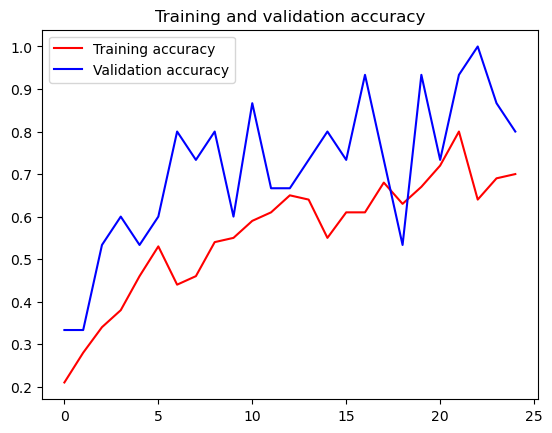

<Figure size 640x480 with 0 Axes>

In [18]:
# Evaluate the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

model = InceptionV3(
            include_top=True,
            weights="imagenet",
            input_tensor=None,
            input_shape=None,
            pooling=None,
            classes=10,
            classifier_activation="softmax",
        )

# REFERENCES
- [Keras image classification use cases](https://keras.io/api/applications/#usage-examples-for-image-classification-models)
- [Transfer learning](https://keras.io/guides/transfer_learning/)
- [DeepLearningAi Tutorial on Transfer Learning](https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C2/W4/ungraded_lab/C2_W4_Lab_1_multi_class_classifier.ipynb)